In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this file, we are going to train a model to recognise hand written number from 0 - 9. We will first start by learning how to train a model to recognise 3, 7. Then, we will further develop the model to recognise 0 - 9. 

Basic setup for fastbook

In [3]:
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 14.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 33.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

**Data preparation**

In this section, we will prepare the data to be used for our model training.

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
#hide
Path.BASE_PATH = path

Check the data we download

In [7]:
path.ls()
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

Setup data for threes and sevens

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

Check my data

In [9]:
image3_path = threes[0]
im3 = Image.open(image3_path)
im3

In [10]:
im3_t = tensor(im3)
im3_t.shape

torch.Size([28, 28])

First we establish our baseline model. For our baseline model we want our model to be simple to implement, which we can use this model to measure our model against further models.

In [11]:
# Get the average value for each pixles.
threes_tensor = [tensor(Image.open(o)) for o in threes]
sevens_tensor = [tensor(Image.open(o)) for o in sevens]

In [12]:
stacked_threes = torch.stack(threes_tensor).float()/255
stacked_sevens = torch.stack(sevens_tensor).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

<Axes: >

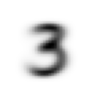

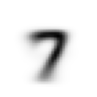

In [13]:
# mean for three
mean3 = stacked_threes.mean(0) # how can I measure the differen between the predicted and actual?
show_image(mean3)

# mean for seven
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [29]:
actual_three = stacked_threes[2]
dist_ab3 = (actual_three - mean3).abs().mean()
dist_ss3 = ((actual_three -mean3)**2).mean().sqrt()

dist_ab3, dist_ss3

(tensor(0.1100), tensor(0.1980))

In [31]:
dist_ab7 = (actual_three - mean7).abs().mean()
dist_ss3 = ((actual_three - mean7)**2).mean().sqrt()

dist_ab7, dist_ss3

(tensor(0.1541), tensor(0.2974))

The Fastai has the api for calculating the loss function

In [32]:
F.l1_loss(actual_three.float(), mean7), F.mse_loss(actual_three, mean7).sqrt()

(tensor(0.1541), tensor(0.2974))